In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [24]:
data_train = pd.read_csv('/content/drive/MyDrive/Pengembangan_ML/weatherHistory.csv')
data_train

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
10275,2007-12-10 03:00:00.000 +0100,Foggy,rain,4.416667,2.933333,0.89,6.4239,71.0,2.9624,0.0,1001.81,Foggy starting in the afternoon continuing unt...
10276,2007-12-10 04:00:00.000 +0100,Foggy,rain,4.938889,2.144444,0.90,12.3004,84.0,3.1234,0.0,1000.93,Foggy starting in the afternoon continuing unt...
10277,2007-12-10 05:00:00.000 +0100,Overcast,rain,6.011111,6.011111,0.80,3.5581,97.0,3.8801,0.0,1000.65,Foggy starting in the afternoon continuing unt...
10278,2007-12-10 06:00:00.000 +0100,Overcast,rain,5.000000,2.733333,0.86,9.7405,50.0,3.8801,0.0,1000.63,Foggy starting in the afternoon continuing unt...


In [25]:
data_train.isnull().sum()

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64

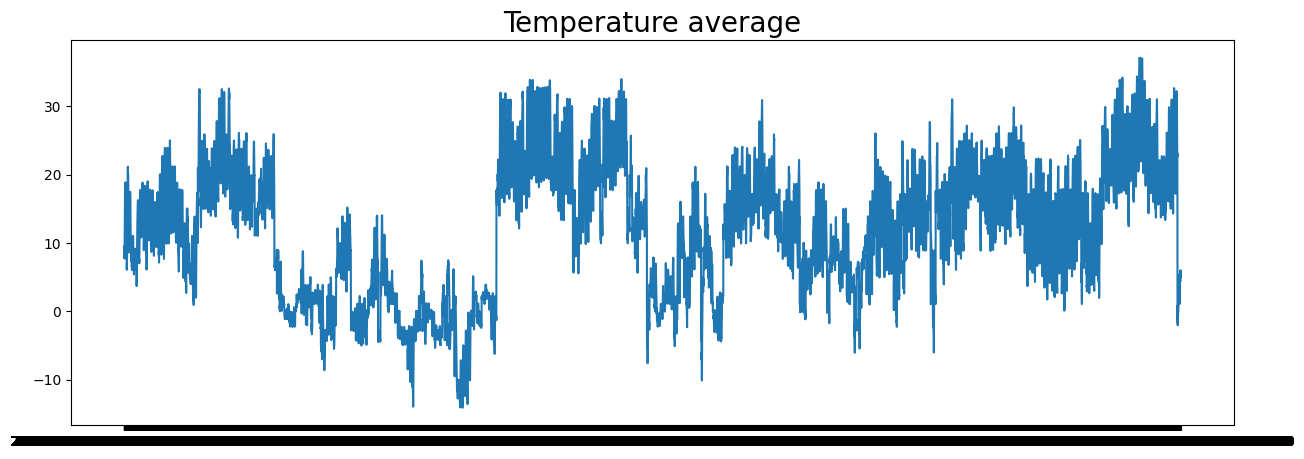

In [10]:
dates = data_train['Formatted Date'].values
temp  = data_train['Temperature (C)'].values


plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

In [27]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [28]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled_prices = sc.fit_transform(temp.reshape(-1,1))

In [29]:
sc_y = scaled_prices.reshape(-1)

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dates, sc_y, shuffle=False, test_size=0.2)

In [31]:
train_set = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
validation_set = windowed_dataset(y_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [32]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [33]:
threshold_mae = (sc_y.max() - sc_y.min()) * 10/100

print("max mae: "+str(threshold_mae))

max mae: 0.5297825070029064


In [34]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, logs={}):
    if(logs.get('mae')>threshold_mae):
      print("\n Mae telah mencapai batas maksimum >"+str(threshold_mae))
      self.model.stop_training = True

callbacks = myCallback()

In [35]:
history = model.fit(train_set,
                    epochs=20,
                    validation_data=validation_set,
                    callbacks=[callbacks])

Epoch 1/20
82/82 [==============================] - 19s 161ms/step - loss: 0.1599 - mae: 0.4519 - val_loss: 0.1708 - val_mae: 0.4819
Epoch 2/20
82/82 [==============================] - 14s 164ms/step - loss: 0.0768 - mae: 0.3130 - val_loss: 0.1113 - val_mae: 0.3854
Epoch 3/20
82/82 [==============================] - 12s 144ms/step - loss: 0.0480 - mae: 0.2400 - val_loss: 0.0560 - val_mae: 0.2609
Epoch 4/20
82/82 [==============================] - 12s 149ms/step - loss: 0.0280 - mae: 0.1769 - val_loss: 0.0277 - val_mae: 0.1765
Epoch 5/20
82/82 [==============================] - 12s 144ms/step - loss: 0.0222 - mae: 0.1535 - val_loss: 0.0267 - val_mae: 0.1755
Epoch 6/20
82/82 [==============================] - 15s 176ms/step - loss: 0.0199 - mae: 0.1444 - val_loss: 0.0211 - val_mae: 0.1556
Epoch 7/20
82/82 [==============================] - 12s 143ms/step - loss: 0.0184 - mae: 0.1369 - val_loss: 0.0213 - val_mae: 0.1570
Epoch 8/20
82/82 [==============================] - 12s 143ms/step - 